<img src="images/BDG_LOGO.png" alt="drawing" align="right" width="200"/>

# H2020 RIA BigDataGrapes - Predictive Data Analytics (T4.3)

## This deliverable (D4.3) presents how to train machine learning models with the BigDataGrapes distributed processing architecture. In particular, we present how to train regressors with MLLib (https://spark.apache.org/mllib/).

In [1]:
from pyspark import SparkContext

In [2]:
import math
import numpy as np
import random
from pyspark.mllib.regression import LabeledPoint

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

## Connection to the BDG Apache Spark

In [4]:
# standalone mode below
#sc = SparkContext(appName="Regression-Synthetic", master="master[*]")

# distributed mode below
sc = SparkContext(appName="Regression-Synthetic", master="spark://spark-master:7077")

# setting logger level
sc.setLogLevel("ERROR")

## Data Generation (linear, square and sin)

### For each of the three arrays we define two versions: the first one is the exact one. The second one takes the exact one and perturbated it with some gaussian error (mean = 0, variance = epsilon).

In [5]:
def lin_formula(x):
    return -1.5 + x * 0.5
def sq_formula(x):
    return -1.5 + 0.5 * (x-(interval[1]-interval[0])/2.0) ** 2
def sin_formula(x):
    return -0.5 + np.sin(x/0.75)

def add_error(x, epsilon=0):
    return x + np.random.normal(0, epsilon, x.shape)

In [6]:
number_points = 200
std_dev = 0.15
interval = (0, 5)

In [7]:
real_x = np.linspace(interval[0], interval[1], (interval[1]-interval[0])*100)
random_x = np.random.uniform(interval[0], interval[1], number_points)

In [8]:
real_lin = lin_formula(real_x)
real_sq = sq_formula(real_x)
real_sin = sin_formula(real_x)

random_lin = add_error(lin_formula(random_x), std_dev)
random_sq = add_error(sq_formula(random_x), std_dev)
random_sin = add_error(sin_formula(random_x), std_dev)

### Plotting generated data (exact)

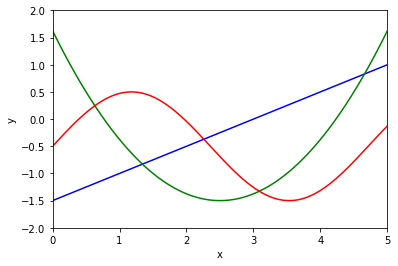

In [9]:
plt.plot(real_x, real_lin, c="b")
plt.plot(real_x, real_sq, c="g")
plt.plot(real_x, real_sin, c="r")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

### Plotting generated data (random)

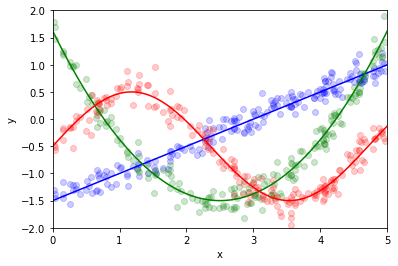

In [10]:
plt.scatter(random_x, random_lin, c="b", alpha=0.2)
plt.scatter(random_x, random_sq, c="g", alpha=0.2)
plt.scatter(random_x, random_sin, c="r", alpha=0.2)
plt.plot(real_x, real_lin, c="b", alpha=1)
plt.plot(real_x, real_sq, c="g", alpha=1)
plt.plot(real_x, real_sin, c="r", alpha=1)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

## Reading data with Apache Spark (creating RDDs)

### This is needed because the data generated are stored in NumPy arrays. We now need to transform them to Spark RDD data structures 

In [11]:
rdd_real_x = sc.parallelize(real_x).map(lambda x: np.array([x]))

### Is the transformation ok? Let's print the first 10 items of the RDD.

In [12]:
rdd_real_x.take(10)

[array([0.]),
 array([0.01002004]),
 array([0.02004008]),
 array([0.03006012]),
 array([0.04008016]),
 array([0.0501002]),
 array([0.06012024]),
 array([0.07014028]),
 array([0.08016032]),
 array([0.09018036])]

# Linear Regression

## Now training three linear regressors. One for each of the three samples generated.

### The three regressors share the same parameters (defined in params). We also measure the time needed by MLLib to train each of them.

In [13]:
from pyspark.mllib.regression import LinearRegressionWithSGD

In [14]:
def transform_to_rdd(x,y):
    return sc.parallelize(np.column_stack((x, y)))\
        .map(lambda x_y: LabeledPoint(x_y[1], np.array([x_y[0]])))

In [15]:
params = {
    "iterations": 100,
    "step": 1,
    "intercept": True
}

%time lin_model = LinearRegressionWithSGD.train(transform_to_rdd(random_x, random_lin), **params)
%time sq_model = LinearRegressionWithSGD.train(transform_to_rdd(random_x, random_sq), **params)
%time sin_model = LinearRegressionWithSGD.train(transform_to_rdd(random_x, random_sin), **params)

/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


CPU times: user 128 ms, sys: 56 ms, total: 184 ms
Wall time: 9.88 s
CPU times: user 92 ms, sys: 76 ms, total: 168 ms
Wall time: 5.49 s
CPU times: user 88 ms, sys: 56 ms, total: 144 ms
Wall time: 3.89 s


In [16]:
pred_lin = lin_model.predict(rdd_real_x).collect()
pred_sq = sq_model.predict(rdd_real_x).collect()
pred_sin = sin_model.predict(rdd_real_x).collect()

## Now plotting exact (shaded lines) and random data (shaded points) and predictions (solid lines).

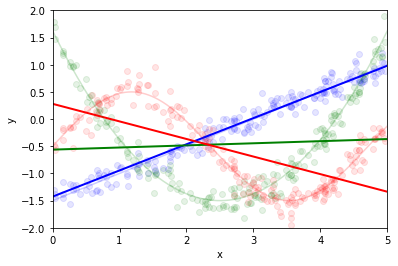

In [17]:
plt.plot(real_x, pred_lin, c="b", linewidth=2)
plt.plot(real_x, pred_sq, c="g", linewidth=2)
plt.plot(real_x, pred_sin, c="r", linewidth=2)
plt.scatter(random_x, random_lin, c="b", alpha=0.1)
plt.scatter(random_x, random_sq, c="g", alpha=0.1)
plt.scatter(random_x, random_sin, c="r", alpha=0.1)
plt.plot(real_x, real_lin, c="b", alpha=0.2)
plt.plot(real_x, real_sq, c="g", alpha=0.2)
plt.plot(real_x, real_sin, c="r", alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

# Random Forest Regression

## Now training three random forest regressors. One for each of the three samples generated.

### The three regressors share the same parameters (defined in params). We also measure the time needed by MLLib to train each of them.

In [18]:
from pyspark.mllib.tree import RandomForest

In [19]:
params = {
    "categoricalFeaturesInfo":{},
    "numTrees":50,
    "featureSubsetStrategy":"auto",
    "maxDepth":8,
    "maxBins":64
}
%time lin_model = RandomForest.trainRegressor(transform_to_rdd(random_x, random_lin), **params)
%time sq_model = RandomForest.trainRegressor(transform_to_rdd(random_x, random_sq), **params)
%time sin_model = RandomForest.trainRegressor(transform_to_rdd(random_x, random_sin), **params)

CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 3.19 s
CPU times: user 16 ms, sys: 20 ms, total: 36 ms
Wall time: 1.7 s
CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 1.64 s


In [20]:
pred_lin = lin_model.predict(rdd_real_x).collect()
pred_sq = sq_model.predict(rdd_real_x).collect()
pred_sin = sin_model.predict(rdd_real_x).collect()

## Now plotting exact (shaded lines) and random data (shaded points) and predictions (solid lines).

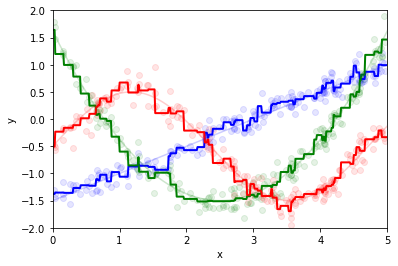

In [21]:
plt.plot(real_x, pred_lin, c="b", linewidth=2)
plt.plot(real_x, pred_sq, c="g", linewidth=2)
plt.plot(real_x, pred_sin, c="r", linewidth=2)
plt.scatter(random_x, random_lin, c="b", alpha=0.1)
plt.scatter(random_x, random_sq, c="g", alpha=0.1)
plt.scatter(random_x, random_sin, c="r", alpha=0.1)
plt.plot(real_x, real_lin, c="b", alpha=0.2)
plt.plot(real_x, real_sq, c="g", alpha=0.2)
plt.plot(real_x, real_sin, c="r", alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(interval)
plt.ylim((-2,2))
plt.show()

## Saving RDDs to BDG HDFS

In [ ]:
rdd_real_x.saveAsTextFile("dataset.csv")

## Disconnection from the BDG Apache Spark

In [23]:
sc.stop()